# Indeed.com Job Analysis - Python 3.5

<img src="./image/indeed_data_scientist_keyword.png" width="300px" align="left">      

      
### Tutorial  
* Web Scraping Indeed for Key Data Science Job Skills [link](https://jessesw.com/Data-Science-Skills/)
* Percent-Encoding Reserved Characters [link](https://en.wikipedia.org/wiki/Percent-encoding) 

### Libraries
* This tutorial requires a few python libraries
  * BeautifulSoup4
  * NLTK [[guide]](http://www.nltk.org/install.html)
  * Download NLTK data [[guide]](http://www.nltk.org/data.html)
  * urllib2 or urllib3   
  
> ```pip install beautifulsoup4
pip install -U nltk```

In [2]:
# import libraries

from bs4 import BeautifulSoup # For HTML parsing
import urllib # Website connections
import requests
import re # Regular expressions
from time import sleep # To prevent overwhelming the server between connections
from collections import Counter # Keep track of our term counts
from nltk.corpus import stopwords # Filter out stopwords, such as 'the', 'or', 'and'
import pandas as pd # For converting results to a dataframe and bar chart plots
import matplotlib
import nltk
import random

In [11]:
# function to cleanup text
def headers():
    i = random.randint(3,5)
    j=random.randint(40,53)
    x=random.randint(2,13)
    url_base = 'https://www.indeed.ca/jobs?q='
    headers ={
            'User-Agent':'Mozilla/'+str(i)+'.0 (Macintosh; Intel Mac OS X 10.'+str(x)+'; rv:53.0) Gecko/20100101 Firefox/'+str(j)+'.0'
                }
    return headers

def text_cleaner(website):
    '''
    This function just cleans up the raw html so that I can look at it.
    Inputs: a URL to investigate
    Outputs: Cleaned text only
    '''
    try:
        site = requests.get(website, headers = headers()) # Connect to the job posting
    except: 
        return   # Need this in case the website isn't there anymore or some other weird connection problem 

    soup_obj = BeautifulSoup(site.text, "html.parser") # Get the html from the site

    for script in soup_obj(["script", "style"]):
        script.extract() # Remove these two elements from the BS4 object

    text = soup_obj.get_text() # Get the text from this
    lines = (line.strip() for line in text.splitlines()) # break into lines
    chunks = (phrase.strip() for line in lines for phrase in line.split("  ")) # break multi-headlines into a line each

    def chunk_space(chunk):
        chunk_out = chunk + ' ' # Need to fix spacing issue
        return chunk_out  

    text = ''.join(chunk_space(chunk) for chunk in chunks if chunk).encode('utf-8') # Get rid of all blank lines and ends of line

    # Now clean out all of the unicode junk (this line works great!!!)
    try:
        text = text.decode('unicode_escape').encode('ascii', 'ignore') # Need this as some websites aren't formatted
    except:                                                            # in a way that this works, can occasionally throw
        return                                                         # an exception

    text = re.sub(r"[^a-zA-Z.+3]"," ", str(text))  # Now get rid of any terms that aren't words (include 3 for d3.js)
                                                # Also include + for C++

    text = text.lower().split()  # Go to lower case and split them apart
    stop_words = set(stopwords.words("english")) # Filter out any stop words
    text = [w for w in text if not w in stop_words]
    text = list(set(text)) # Last, just get the set of these. Ignore counts (we are just looking at whether a term existed
                            # or not on the website)
    return text

# note the function itself doesn't return anything if you run this cell





# The skills_info function prints out a list of skillset keywords ordered by popularity
def skills_info(city = None, state = None, job_title = None):
    '''
    This function will take a desired city/state and look for all new job postings
    on Indeed.com. It will crawl all of the job postings and keep track of how many
    use a preset list of typical data science skills. The final percentage for each skill
    is then displayed at the end of the collation. 

    Inputs: The location's city and state. These are optional. If no city/state is input, 
    the function will assume a national search (this can take a while!!!).
    Input the city/state as strings, such as skills_info('Chicago', 'IL').
    Use a two letter abbreviation for the state.

    Output: A bar chart showing the most commonly desired skills in the job market for 
    a data scientist. 
    '''

    #final_job = 'data+scientist' # searching for data scientist exact fit("data scientist" on Indeed search)

    final_job = str(job_title)
    
    # Make sure the city specified works properly if it has more than one word (such as San Francisco)
    if city is not None:
        final_city = city.split() 
        final_city = '+'.join(word for word in final_city)
        final_site_list = ['http://ca.indeed.com/jobs?q=', final_job, '&l=', final_city,
                    '%2C+', state] # Join all of our strings together so that indeed will search correctly
    else:
        final_site_list = ['http://ca.indeed.com/jobs?q="', final_job, '"']

    final_site = ''.join(final_site_list) # Merge the html address together into one string
    print(final_site)

    base_url = 'http://ca.indeed.com'


    try:
        html = requests.get(final_site, headers = headers()) # Open up the front page of our search first
    except:
        print('That city/state combination did not have any jobs. Exiting . . .') # In case the city is invalid
        return
    soup = BeautifulSoup(html.text, 'html.parser') # Get the html from the first page

    # Now find out how many jobs there were

    num_jobs_area = soup.find(id = 'searchCount').string.encode('utf-8') # Now extract the total number of jobs found
                                                                        # The 'searchCount' object has this

    job_numbers = re.findall(r'\d+', str(num_jobs_area)) # Extract the total jobs found from the search result


    if len(job_numbers) > 3: # Have a total number of jobs greater than 1000
        total_num_jobs = (int(job_numbers[2])*1000) + int(job_numbers[3])
    else:
        total_num_jobs = int(job_numbers[2]) 

    city_title = city
    if city is None:
        city_title = 'Nationwide'

    print('There were', total_num_jobs, 'jobs found,', city_title) # Display how many jobs were found

    num_pages = total_num_jobs//10 # This will be how we know the number of times we need to iterate over each new
                                      # search result page
    job_descriptions = [] # Store all our descriptions in this list
    
    for i in range(1,min(num_pages+2,999)): # Loop through all of our search result pages   
    #for i in range(1,5):   # Loop through some of our search result pages(testing)
        print('Getting page', i)
        start_num = str(i*10) # Assign the multiplier of 10 to view the pages we want
        current_page = ''.join([final_site, '&start=', start_num])
        # Now that we can view the correct 10 job returns, start collecting the text samples from each

        html_page = requests.get(current_page, headers = headers()) # Get the page

        page_obj = BeautifulSoup(html_page.text,'html.parser') # Locate all of the job links
        job_link_area = page_obj.find(id = 'resultsCol') # The center column on the page where the job postings exist

        job_URLS = [str(base_url) + str(link.get('href')) for link in job_link_area.find_all('a')] # Get the URLS for the jobs
        job_URLS1=[]
        # job_URLS = filter(lambda x:'clk' in x, job_URLS) # Now get just the job related URLS
        for abc in job_URLS:
            if re.findall(r'clk', abc):
                continue
            else:
                job_URLS1.append(abc)

        for j in range(0,len(job_URLS1)):
            final_description = text_cleaner(job_URLS1[j])
            if final_description: # So that we only append when the website was accessed correctly
                job_descriptions.append(final_description)
            sleep(0) # So that we don't be jerks. If you have a very fast internet connection you could hit the server a lot! 

    print('Done with collecting the job postings!')    
    print('There were' + str(len(job_descriptions)) + 'jobs successfully found.')


    doc_frequency = Counter() # This will create a full counter of our terms. 
    [doc_frequency.update(item) for item in job_descriptions] # List comp

    # Now we can just look at our final dict list inside doc_frequency

    # Obtain our key terms and store them in a dict. These are the key data science skills we are looking for

    prog_lang_dict = Counter({'R':doc_frequency['r'], 'Python':doc_frequency['python'],
                    'Java':doc_frequency['java'], 'C++':doc_frequency['c++'],
                    'Ruby':doc_frequency['ruby'],
                    'Perl':doc_frequency['perl'], 'Matlab':doc_frequency['matlab'],
                    'JavaScript':doc_frequency['javascript'], 'Scala': doc_frequency['scala']})

    analysis_tool_dict = Counter({'Excel':doc_frequency['excel'],  'Tableau':doc_frequency['tableau'],
                        'D3.js':doc_frequency['d3.js'], 'SAS':doc_frequency['sas'],
                        'SPSS':doc_frequency['spss'], 'D3':doc_frequency['d3']})  

    hadoop_dict = Counter({'Hadoop':doc_frequency['hadoop'], 'MapReduce':doc_frequency['mapreduce'],
                'Spark':doc_frequency['spark'], 'Pig':doc_frequency['pig'],
                'Hive':doc_frequency['hive'], 'Shark':doc_frequency['shark'],
                'Oozie':doc_frequency['oozie'], 'ZooKeeper':doc_frequency['zookeeper'],
                'Flume':doc_frequency['flume'], 'Mahout':doc_frequency['mahout']})

    database_dict = Counter({'SQL':doc_frequency['sql'], 'NoSQL':doc_frequency['nosql'],
                    'HBase':doc_frequency['hbase'], 'Cassandra':doc_frequency['cassandra'],
                    'MongoDB':doc_frequency['mongodb']})


    overall_total_skills = prog_lang_dict + analysis_tool_dict + hadoop_dict + database_dict # Combine our Counter objects



    final_frame = pd.DataFrame(list(overall_total_skills.items()), columns=['Term','NumPostings']) # Convert these terms to a dataframe 
    
    # Change the values to reflect a percentage of the postings 

    final_frame.NumPostings = (final_frame.NumPostings)*100/len(job_descriptions) # Gives percentage of job postings 
                                                                                    #  having that term 

    # Sort the data for plotting purposes

    final_frame.sort_values(by = 'NumPostings', ascending = False, inplace = True)

    # Get it ready for a bar plot

    final_plot = final_frame.plot(x = 'Term', kind = 'bar', legend = None, 
                            title = 'Percentage of Data Scientist Job Ads on Indeed, ' + city_title)

    final_plot.set_ylabel('Percentage Appearing in Job Ads')
    fig = final_plot.get_figure() # Have to convert the pandas plot object to a matplotlib object
    return fig #,final_frame # End of the function

http://ca.indeed.com/jobs?q=Data+Scientist&l=Toronto%2C+ON
There were 325 jobs found, Toronto
Getting page 1
Getting page 2


/Users/vicyan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: invalid escape sequence '\*'


Getting page 3


/Users/vicyan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: invalid escape sequence '\ '


Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15
Getting page 16
Getting page 17
Getting page 18
Getting page 19
Getting page 20
Getting page 21
Getting page 22
Getting page 23
Getting page 24
Getting page 25
Getting page 26
Getting page 27
Getting page 28
Getting page 29
Getting page 30
Getting page 31
Getting page 32
Getting page 33
Done with collecting the job postings!
There were3523jobs successfully found.


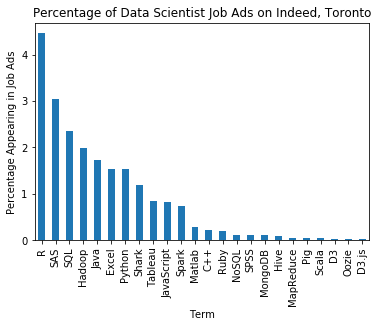

In [12]:
# Data Scientist job keywords in Mississauga
skills_info(city = 'Toronto', state = 'ON', job_title='Data+Scientist')

http://ca.indeed.com/jobs?q=Data+Engineer&l=Toronto%2C+ON
There were 1547 jobs found, Toronto
Getting page 1
Getting page 2
Getting page 3


/Users/vicyan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: invalid escape sequence '\*'


Getting page 4
Done with collecting the job postings!
There were401jobs successfully found.


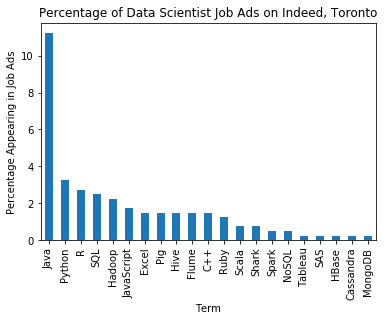

In [7]:
# Data Engineer job keywords in Mississauga
skills_info(city = 'Toronto', state = 'ON', job_title='Data+Engineer')

http://ca.indeed.com/jobs?q=Business+Analyst&l=Toronto%2C+ON
There were 4241 jobs found, Toronto
Getting page 1


/Users/vicyan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: invalid escape sequence '\A'
/Users/vicyan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: invalid escape sequence '\ '


Getting page 2
Getting page 3


/Users/vicyan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: invalid escape sequence '\C'


Getting page 4
Done with collecting the job postings!
There were419jobs successfully found.


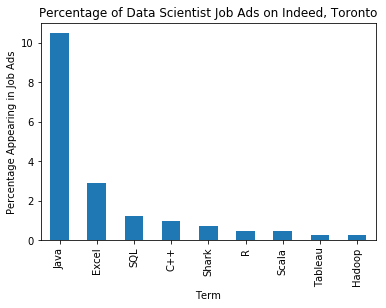

In [8]:
# Data Engineer job keywords in Mississauga
skills_info(city = 'Toronto', state = 'ON', job_title='Business+Analyst') 

In [9]:
# Data Engineer job keywords in Mississauga
toronto_data_analyst = skills_info(city = 'Toronto', state = 'ON', job_title='Data+Analyst') 

http://ca.indeed.com/jobs?q=Data+Analyst&l=Toronto%2C+ON
There were 2855 jobs found, Toronto
Getting page 1


/Users/vicyan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: invalid escape sequence '\ '


Getting page 2
Getting page 3
Getting page 4
Done with collecting the job postings!
There were439jobs successfully found.


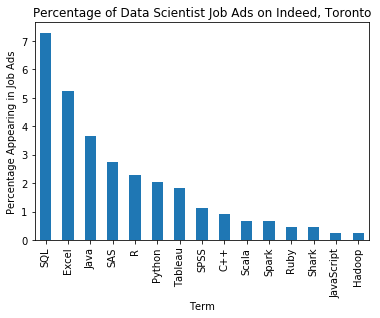

In [10]:
toronto_data_analyst

In [13]:
print a 

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-13-fe8923e71887>, line 1)